In [1]:
#reproduction of code from https://github.com/YvesMSaintDrenan/WT_PowerCurveModel/tree/master

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

Here it is possible to add steps of beta from dataset
adding formulas from latex to explain code.

In [3]:
"""DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"
DATAFailures17 = "data/raw/opendata-wind-failures-2017.xlsx"""

#data from 2016
DATA = "data/raw/Onsite-MetMast-SCADA-data-2016.xlsx"
DATAScada = "data/raw/Wind-Turbine-SCADA-signals-2016.xlsx"
DATAFailures = "data/raw/Historical-Failure-Logbook-2016.xlsx"

data = pd.read_excel(DATA, engine='openpyxl')
"""data17 = pd.read_excel(DATA17, engine='openpyxl')"""

datascada = pd.read_excel(DATAScada, engine='openpyxl')
"""datascada17= pd.read_excel(DATAScada17, engine="openpyxl")"""

datafailures = pd.read_excel(DATAFailures, engine="openpyxl")

merged_df = pd.merge(datascada, data, on="Timestamp", how="inner")

In [4]:
#only looking at t07 or specified turbine
merged_df = merged_df[merged_df["Turbine_ID"] == "T07"]

In [25]:
merged_df

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,dbscan_outlier_rule1
3,T07,2016-01-08T23:10:00+00:00,1654.7,1247.6,1480.6,106.6,46,71,71,70,...,0.0499,0.24,1,0,0,600,164,166,406,False
5,T07,2016-04-19T12:20:00+00:00,1766.4,1591.8,1681.7,26.1,66,124,122,118,...,0.0499,0.24,1,0,0,600,258,259,405,False
11,T07,2016-04-19T12:30:00+00:00,1777.7,1562.6,1675.3,31.3,67,124,123,118,...,0.0499,0.24,1,0,0,600,187,188,405,False
12,T07,2016-01-08T23:50:00+00:00,1667.5,1277.4,1481.3,119.1,46,73,72,71,...,0.0499,0.24,1,0,0,600,157,158,405,False
16,T07,2016-04-19T12:40:00+00:00,1749.1,1585.4,1667.3,27.0,67,123,122,117,...,0.0499,0.24,1,0,0,600,160,160,405,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207876,T07,2016-04-23T09:20:00+00:00,133.0,42.0,84.3,24.3,24,28,28,27,...,0.0499,0.24,1,0,0,600,57,56,409,False
207883,T07,2016-07-01T11:10:00+00:00,1309.1,1213.9,1253.5,15.3,44,61,61,60,...,0.0499,0.24,1,0,0,600,83,71,410,False
207884,T07,2016-07-11T00:50:00+00:00,1680.9,1439.7,1595.4,55.5,50,74,74,73,...,0.0499,0.24,1,0,0,600,142,144,407,False
207888,T07,2016-10-14T12:50:00+00:00,1337.3,1184.0,1262.5,20.1,42,64,64,64,...,0.0499,0.24,1,0,0,600,80,80,403,False


## data preprocessing:

In [ ]:
#Amb_WindSpeed_Avg, Grd_Prod_Pwr_Avg, Rtr_RPM_Avg Gen_RPM_Avg
# Define the outlier rules
outliers_rule_1 = merged_df[(merged_df['Rtr_RPM_Avg'] == 0) & (merged_df['Amb_WindSpeed_Avg'] >= 4)]
outliers_rule_2 = merged_df[(merged_df['Grd_Prod_Pwr_Avg'] <= 0) & 
                            (merged_df['Amb_WindSpeed_Avg'] < 4) & 
                            (merged_df['Rtr_RPM_Avg'] > 0)]
outliers_rule_3 = merged_df[(merged_df['Grd_Prod_Pwr_Avg'] <= 0) & 
                            (merged_df['Amb_WindSpeed_Avg'] >= 4) & 
                            (merged_df['Rtr_RPM_Avg'] > 0)]

# Combine all outliers
all_outliers = pd.concat([outliers_rule_1, outliers_rule_2, outliers_rule_3]).drop_duplicates()

# Remove outliers from merged_df
merged_df = merged_df[~merged_df.index.isin(all_outliers.index)]


In [ ]:
#First test, has everything in it

from sklearn.cluster import DBSCAN

# Assuming merged_df has already been loaded with the necessary columns

# Rule 1: DBSCAN on Ambient Wind Speed and Grid Produced Power
X_rule1 = merged_df[['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg']].values
dbscan_rule1 = DBSCAN(eps=2, min_samples=10)
labels_rule1 = dbscan_rule1.fit_predict(X_rule1)
merged_df['dbscan_outlier_rule1'] = (labels_rule1 == -1)  # True if outlier, False if not




KeyError: "None of [Index(['Ambient_Wind_Speed', 'Grid_Produced_Power'], dtype='object')] are in the [columns]"

In [ ]:
# Rule 2: DBSCAN on Ambient Wind Speed and Generator RPM
X_rule2 = merged_df[['Amb_WindSpeed_Avg', 'Gen_RPM_Avg']].values
dbscan_rule2 = DBSCAN(eps=3.45, min_samples=10)
labels_rule2 = dbscan_rule2.fit_predict(X_rule2)
merged_df['dbscan_outlier_rule2'] = (labels_rule2 == -1)  # True if outlier, False if not

# Combine outliers from both rules
merged_df['is_dbscan_outlier'] = merged_df['dbscan_outlier_rule1'] | merged_df['dbscan_outlier_rule2']

# Remove outliers directly from merged_df
merged_df = merged_df[~merged_df['is_dbscan_outlier']]

# Drop the temporary columns used for outlier labeling
merged_df = merged_df.drop(columns=['dbscan_outlier_rule1', 'dbscan_outlier_rule2', 'is_dbscan_outlier'])

In [22]:
from hdbscan import HDBSCAN
import numpy as np

# Fit HDBSCAN on the relevant features
hdbscan = HDBSCAN(min_cluster_size=10)  # You can adjust this parameter as needed
labels_hdbscan = hdbscan.fit_predict(merged_df[['Amb_WindSpeed_Avg', 'Rtr_RPM_Avg']])

# Add labels to the DataFrame for HDBSCAN
merged_df['hdbscan_outlier'] = (labels_hdbscan == -1)  # True if outlier, False if not

# You can now combine outliers from DBSCAN and HDBSCAN if you wish
# merged_df['is_outlier'] = merged_df['dbscan_outlier_rule2'] | merged_df['hdbscan_outlier']


ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
# calculate wind power column
# Calculate actual cp

R = 287.05 # specific gas constant
"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2 rotor area

#air density calculation from dataset with conversion to SI-units
merged_df["airdensity"] = (merged_df["Avg_Pressure"]*100) / (R * (merged_df["Amb_Temp_Avg"]+273.15))

# new column for power in the wind itself. 
merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW

# cp = p_turbine / p_wind
merged_df["cp_actual"] =  merged_df["Grd_Prod_Pwr_Avg"] / merged_df["p_wind"]


C:\Users\47915\AppData\Local\Temp\ipykernel_36744\3293465574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["airdensity"] = (merged_df["Avg_Pressure"]*100) / (R * (merged_df["Amb_Temp_Avg"]+273.15))
C:\Users\47915\AppData\Local\Temp\ipykernel_36744\3293465574.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW
C:\Users\47915\AppData\Local\Temp\ipykernel_36744\3293465574.py:15: SettingWithCop

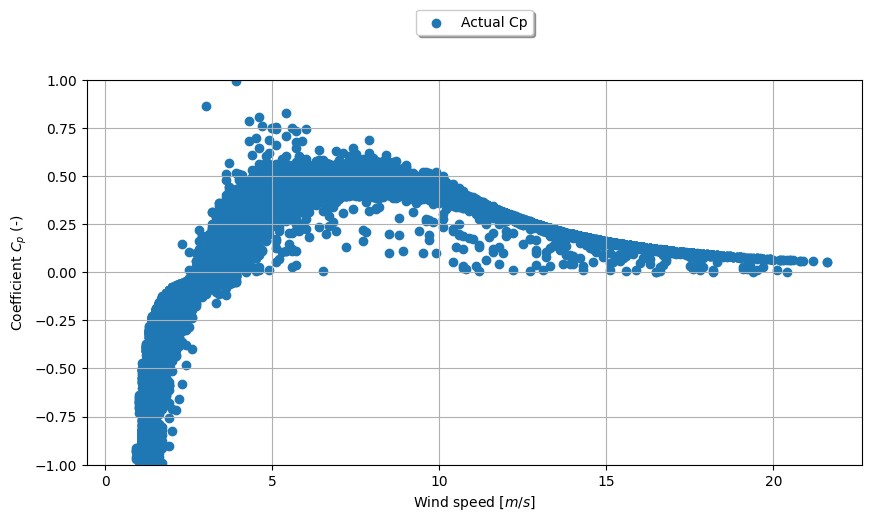

In [ ]:
# Plotting the actual Cp values from merged_df
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["cp_actual"], label='Actual Cp')

# Add labels and grid
plt.xlabel('Wind speed [$m/s$]')  # Placeholder for x-axis label
plt.ylabel('Coefficient $C_p$ (-)')
plt.grid()
plt.ylim(-1,1)
# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

# Show the plot
plt.show()

In the graph above:

- Cut-in wind speed: 3 m/s
- Rated wind speed: 13,5 m/s
- Cut-off wind speed: 25 m/s
\n
tells us that there is a potensial for guessing in the sub 12m/s area.


In [ ]:
conversion_factor = 2 * np.pi / 60
merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (90/2) / merged_df["Amb_WindSpeed_Avg"]

C:\Users\47915\AppData\Local\Temp\ipykernel_36744\1055401984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (90/2) / merged_df["Amb_WindSpeed_Avg"]


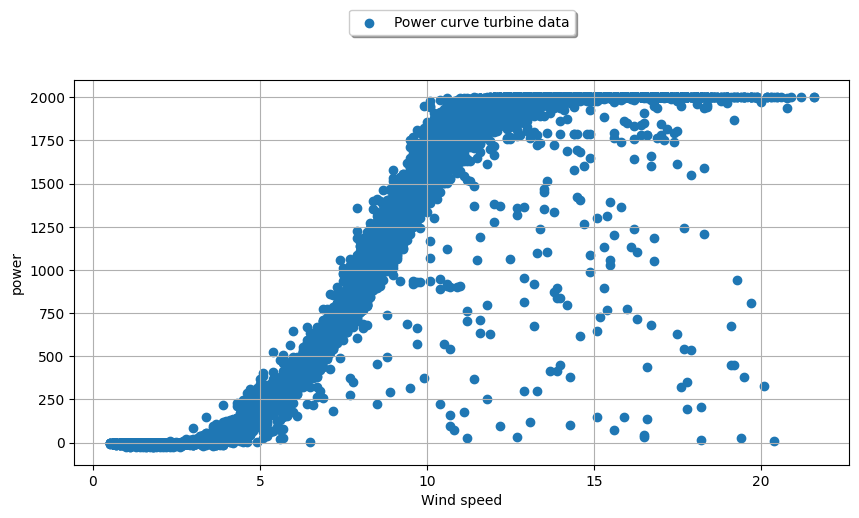

In [ ]:

# Plotting the actual Cp values from merged_df
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], label='Power curve turbine data')

# Add labels and grid
plt.xlabel("Wind speed")  # Placeholder for x-axis label
plt.ylabel("power")
plt.grid()

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

# Show the plot
plt.show()

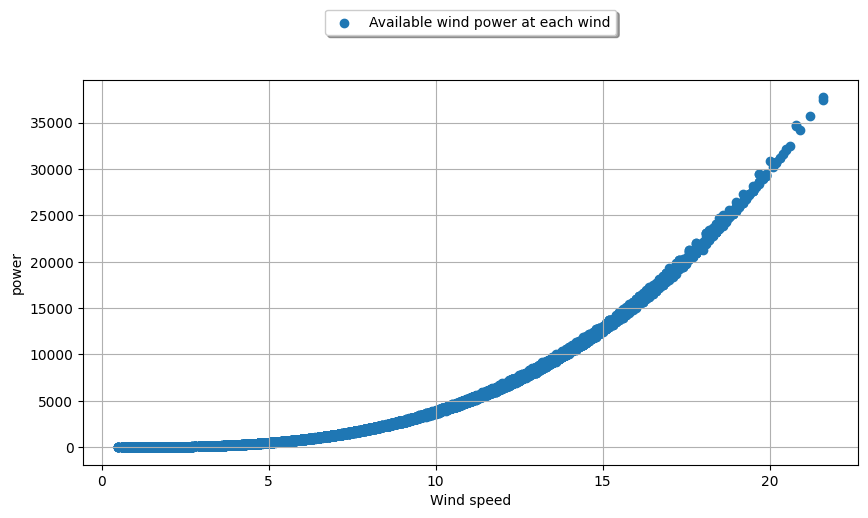

In [ ]:
# Plotting the actual Cp values from merged_df
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["p_wind"], label='Available wind power at each wind')

# Add labels and grid
plt.xlabel("Wind speed")  # Placeholder for x-axis label
plt.ylabel("power")
plt.grid()

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

# Show the plot
plt.show()

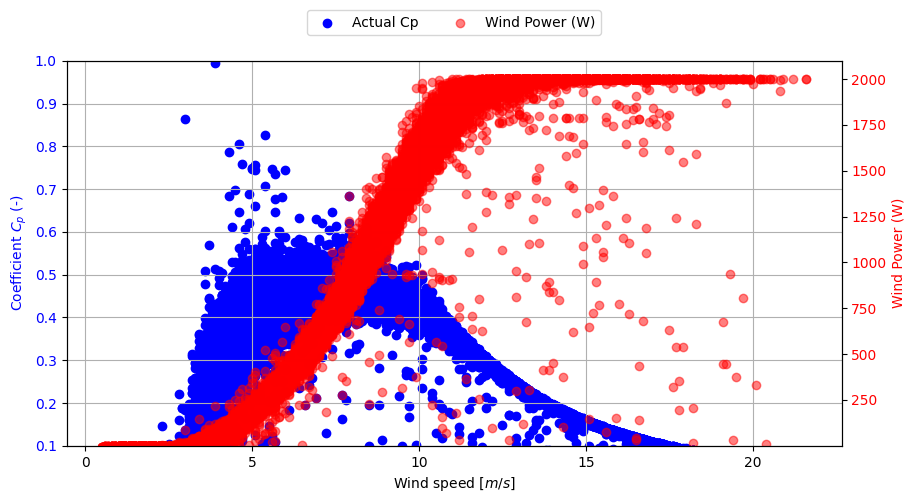

In [ ]:
# Create a scatter plot for the actual Cp values from merged_df
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis
ax1.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["cp_actual"], color='blue', label='Actual Cp')
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Coefficient $C_p$ (-)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')  # Color of y-axis labels
ax1.grid()
ax1.set_ylim(0.1, 1)  # Set y-limits for Cp values

# Create a secondary y-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], color='red', label='Wind Power (W)', alpha=0.5)  # Change to scatter if you prefer dots
ax2.set_ylabel('Wind Power (W)', color='red')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='red')  # Color of second y-axis labels
ax2.set_ylim(0.1, 2100)
# Optional: Add legends for both y-axes
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()


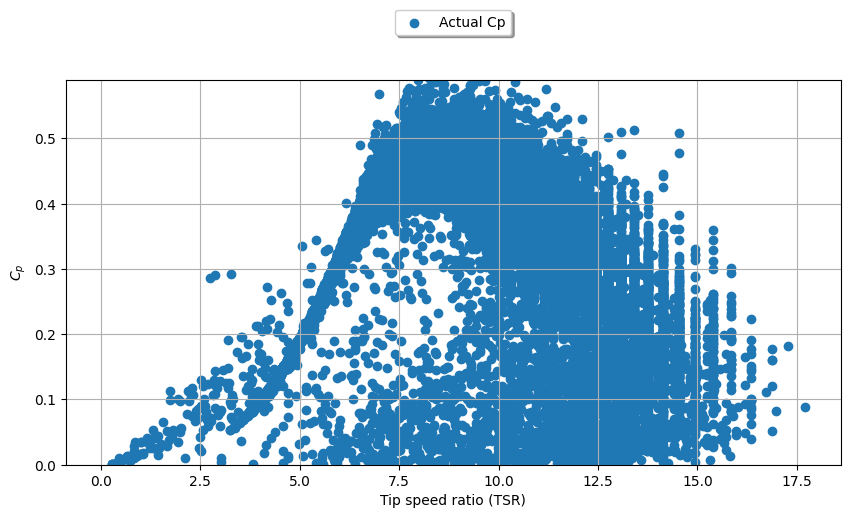

In [ ]:
# Plotting the actual Cp values from merged_df
plt.scatter(merged_df["tsr"], merged_df["cp_actual"], label='Actual Cp')

# Add labels and grid
plt.xlabel("Tip speed ratio (TSR)")  # Placeholder for x-axis label
plt.ylabel("$C_p$")
plt.grid()
plt.ylim(0, 0.59)
# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

# Show the plot
plt.show()

In [ ]:
# change in 

In [ ]:
# theoretical Cp

In [ ]:
# changing type() of "timestamp" for plotting from TimeStamp which was string
merged_df['timestamp'] = pd.to_datetime(merged_df['Timestamp'])

C:\Users\47915\AppData\Local\Temp\ipykernel_36744\2379594715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['timestamp'] = pd.to_datetime(merged_df['Timestamp'])


In [ ]:
# Get the names of columns containing "pwr"
pwr_columns = [col for col in merged_df.columns if 'pwr' in col.lower()]

# Display the first 10 rows of these columns using iloc
first_10_pwr_rows = merged_df.iloc[:5][pwr_columns]
print(first_10_pwr_rows)


    Prod_LatestAvg_ActPwrGen0  Prod_LatestAvg_ActPwrGen1  \
3                           0                   104701.0   
5                           0                   332856.0   
11                          0                   322975.0   
12                          0                   114924.0   
16                          0                   303132.0   

    Prod_LatestAvg_ActPwrGen2  Prod_LatestAvg_TotActPwr  \
3                           0                  104701.0   
5                           0                  332856.0   
11                          0                  322975.0   
12                          0                  114924.0   
16                          0                  303132.0   

    Prod_LatestAvg_ReactPwrGen0  Prod_LatestAvg_ReactPwrGen1  \
3                             0                       -24067   
5                             0                       -36816   
11                            0                       -36346   
12                          

In [ ]:
#This one may have to be modified to take in steps of beta

def CpLambdaModels(Model, TSR, Beta=[]):
    TSR = np.maximum(0.001, TSR)

    if Beta == []:                  # Run TSR as its own function outside? that way we can call it from this function
        Beta=np.zeros(TSR.shape)
    if Model == "constant":             # Optimally we dont want this one to ever happen in the model
        Cp=np.ones(TSR.shape)*0.49
    else:
        if Model=='Slootweg et al. 2003':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.73,151,0.58,0,0.002,13.2,18.4,0,-0.02,0.003
            x=2.14
        elif  Model=='Heier 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0.4,0,0,5,21,0,0.089,0.035
            x=0
        elif  Model=='Thongam et al. 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5176,116,0.4,0,0,5,21,0.006795,0.089,0.035
            x=0
        elif  Model=='De Kooning et al. 2010':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.77,151,0,0,0,13.65,18.4,0,0,0
            x=0
        elif  Model=='Ochieng et Manyonge 2014':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0,0.4,0,5,21,0,0.08,0.035
            x=0
        elif  Model=='Dai et al. 2016':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.22,120,0.4,0,0,5,12.5,0,0.08,0.035
            x=0

        Li=1/(1/(TSR+c9*Beta)-c10/(Beta**3+1)) #Intermediate value. Think of as a correcting factor instead of full aerodynamical model, 

        # Cp value final calculation
        Cp=np.maximum(0,c1*(c2/Li-c3*Beta-c4*Li*Beta-c5*Beta**x-c6)*np.exp(-c7/Li)+c8*TSR)

    return Cp

In [ ]:
def calculate_cp_row(row):
    TSR = row['tsr']
    Beta = row['Blds_PitchAngle_Avg'] * (m.pi / 180)
    Model = "Slootweg et al. 2003"  # Specify your model name here
    return CpLambdaModels(Model, TSR, Beta)

# Add new column to merged_df
merged_df['cp_lambdamodel'] = merged_df.apply(calculate_cp_row, axis=1)

# To return the new column cp_lambdamodel
#result = merged_df['cp_lambdamodel']

C:\Users\47915\AppData\Local\Temp\ipykernel_36744\2302438871.py:33: RuntimeWarning: overflow encountered in exp
  Cp=np.maximum(0,c1*(c2/Li-c3*Beta-c4*Li*Beta-c5*Beta**x-c6)*np.exp(-c7/Li)+c8*TSR)
C:\Users\47915\AppData\Local\Temp\ipykernel_36744\3164937101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cp_lambdamodel'] = merged_df.apply(calculate_cp_row, axis=1)


In [ ]:
print(merged_df['cp_lambdamodel'])

3         0.334075-0.000000j
5         0.376027+0.000000j
11        0.392389+0.000000j
12        0.358880-0.000000j
16        0.434199+0.000000j
                 ...        
207876    0.000000+0.000000j
207883    0.000000+0.000000j
207884    0.373988-0.000000j
207888    0.000000+0.000000j
207891    0.228401+0.000000j
Name: cp_lambdamodel, Length: 42133, dtype: complex128


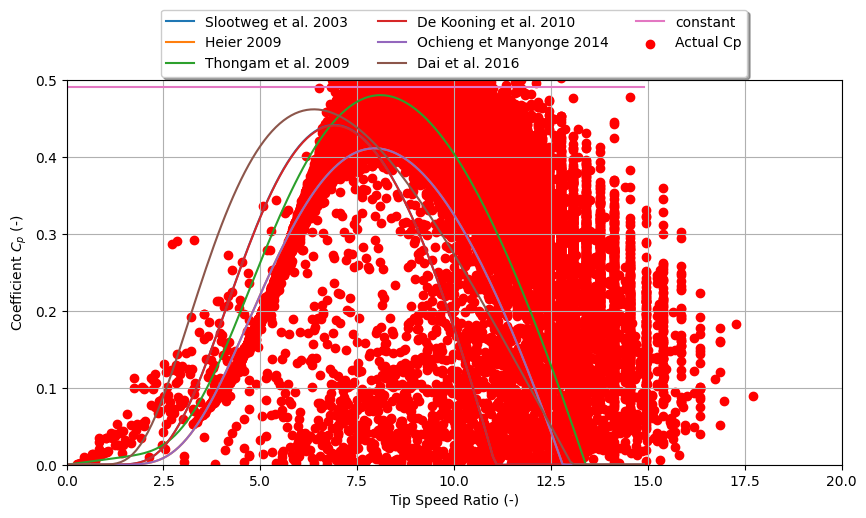

In [ ]:
TSR = np.arange(0, 15, 0.1)

# Plotting the optimal Cp curves for different models
for Model in ['Slootweg et al. 2003', 'Heier 2009', 'Thongam et al. 2009', 
              'De Kooning et al. 2010', 'Ochieng et Manyonge 2014', 'Dai et al. 2016', 'constant']:
    Cp = CpLambdaModels(Model, TSR, Beta=[])
    plt.plot(TSR, Cp, label=Model)

# Plotting actual Cp values from merged_df
plt.scatter(merged_df['tsr'], merged_df['cp_actual'], color='red', label='Actual Cp', marker='o')

# Add labels and grid
plt.xlabel('Tip Speed Ratio (-)')
plt.ylabel('Coefficient $C_p$ (-)')
plt.grid()
plt.xlim(0,20)
plt.ylim(0,0.5)
# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

# Show the plot
plt.show()

C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


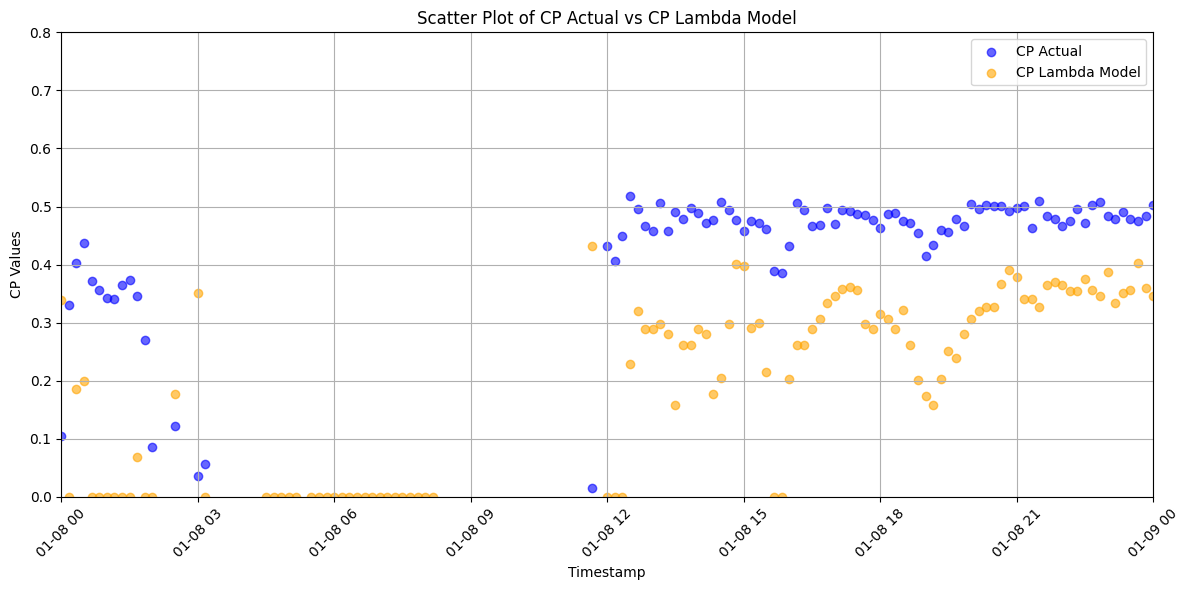

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['timestamp'], merged_df['cp_actual'], color='blue', label='CP Actual', alpha=0.6)
plt.scatter(merged_df['timestamp'], merged_df['cp_lambdamodel'], color='orange', label='CP Lambda Model', alpha=0.6)


#interval
start_date = merged_df['timestamp'].min() + pd.Timedelta(weeks=1)  # Adjust as needed
end_date = start_date + pd.Timedelta(days=1)

# Adding titles and labels
plt.title('Scatter Plot of CP Actual vs CP Lambda Model')
plt.xlabel('Timestamp')
plt.ylabel('CP Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()
plt.ylim(0,0.8)
plt.xlim(start_date, end_date)
# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

C:\Users\47915\AppData\Local\Temp\ipykernel_36744\2818471514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])
Locator attempting to generate 1610 ticks ([16782.833333333332, ..., 17185.083333333332]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1610 ticks ([16782.833333333332, ..., 17185.083333333332]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1610 ticks ([16782.833333333332, ..., 17185.083333333332]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1610 ticks ([16782.833333333332, ..., 17185.083333333332]), which exceeds Locator.MAXTICKS (1000).


<Figure size 1200x600 with 0 Axes>

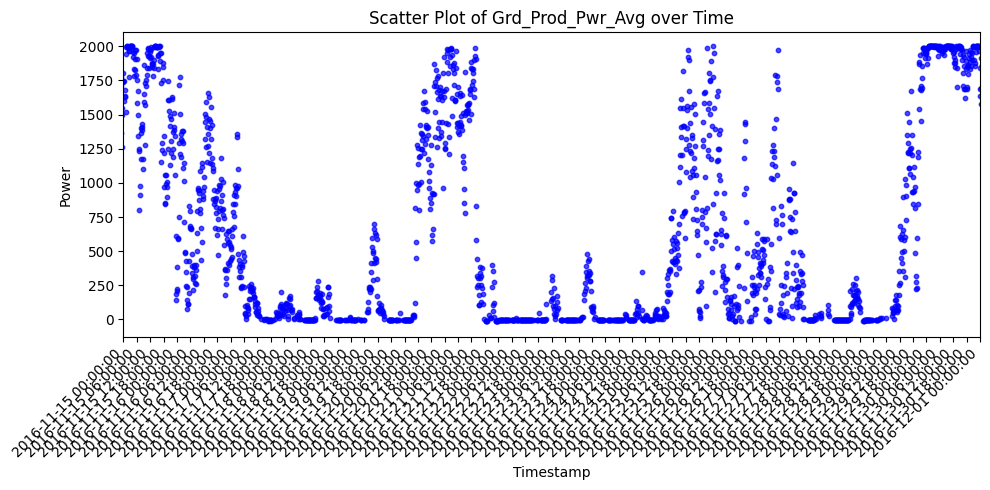

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the timestamp is in datetime format
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

# Set up the figure with a smaller size
plt.figure(figsize=(12, 6))

# Create the scatter plot
ax = merged_df.plot.scatter(x="Timestamp", y="Grd_Prod_Pwr_Avg", s=10, alpha=0.7, color='blue')

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set a less frequent locator to prevent overcrowding (e.g., every 6 hours)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define the x-axis interval (adjust these dates to fit your data)
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.title('Scatter Plot of Grd_Prod_Pwr_Avg over Time')

# Display the plot
plt.tight_layout()  # Adjust layout to fit elements within the figure area
plt.show()


C:\Users\47915\AppData\Local\Temp\ipykernel_36744\3282889144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])


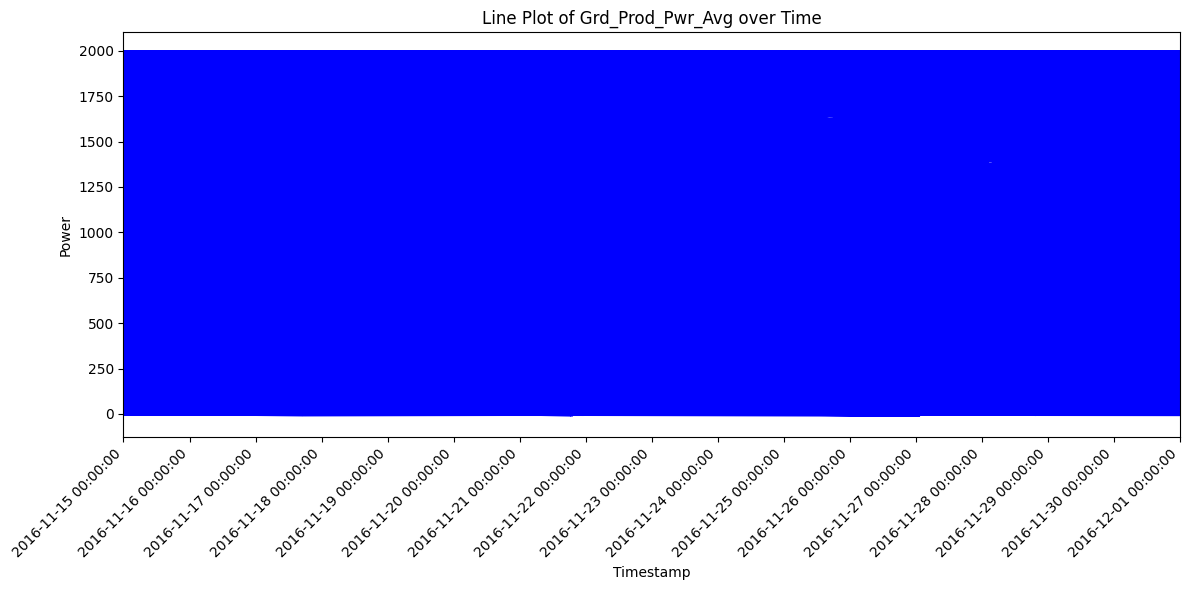

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the timestamp is in datetime format
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

# Set up the figure with a defined size
plt.figure(figsize=(12, 6))

# Plot the data as a line plot
plt.plot(merged_df['Timestamp'], merged_df['Grd_Prod_Pwr_Avg'], color='blue', linewidth=1)

# Customize the format of the timestamp on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set a less frequent locator for x-axis ticks (e.g., every day)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define the x-axis interval (adjust these dates to fit your data)
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.title('Line Plot of Grd_Prod_Pwr_Avg over Time')

# Use tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:

merged_df['cp_difference'] = merged_df['cp_actual'].astype(float) - merged_df['cp_lambdamodel'].astype(float)

# Display the updated DataFrame
print(merged_df[['cp_actual', 'cp_lambdamodel', 'cp_difference']])

        cp_actual      cp_lambdamodel  cp_difference
3        0.478165  0.334075-0.000000j       0.144090
5        0.254067  0.376027+0.000000j      -0.121960
11       0.278109  0.392389+0.000000j      -0.114280
12       0.483487  0.358880-0.000000j       0.124607
16       0.374650  0.434199+0.000000j      -0.059549
...           ...                 ...            ...
207876  -0.660746  0.000000+0.000000j      -0.660746
207883   0.318183  0.000000+0.000000j       0.318183
207884   0.463322  0.373988-0.000000j       0.089334
207888   0.376476  0.000000+0.000000j       0.376476
207891   0.121176  0.228401+0.000000j      -0.107226

[42133 rows x 3 columns]


C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\47915\AppData\Local\Temp\ipykernel_36744\2770202972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cp_difference'] = merged_df['cp_actual'].astype(float) - merged_df['cp_lambdamodel'].astype(float)


(0.0, 1500.0)

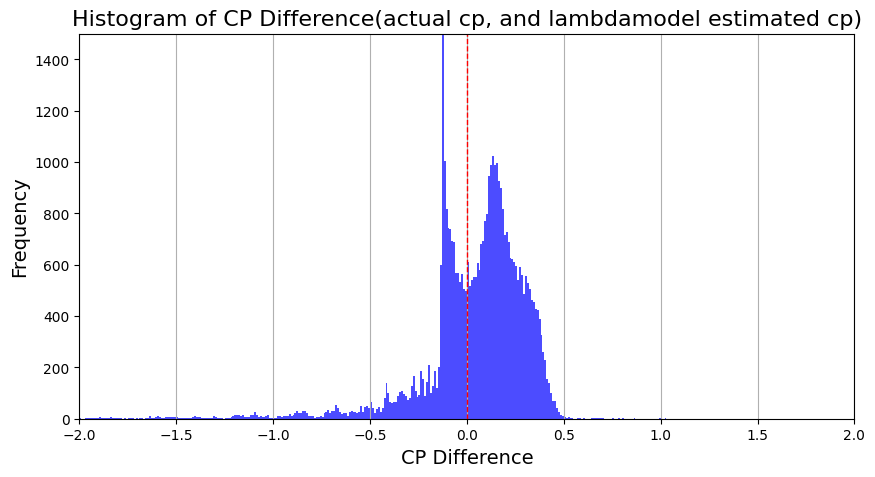

In [ ]:
merged_df["cp_difference"].hist(bins=1000,range=(-5,5), color='blue', alpha=0.7)
plt.title('Histogram of CP Difference(actual cp, and lambdamodel estimated cp)', fontsize=16)
plt.xlabel('CP Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)  # vertical line
plt.xlim(-2, 2)  # adjust if needed (for all comaprable histograms)
plt.grid(axis='y')
plt.ylim(0,1500)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

"""# Calculate the actual error values
errors = merged_df['cp_actual'].astype(float) - merged_df['cp_lambdamodel'].astype(float)"""

# Mean Squared Error (MSE)
mse = mean_squared_error(merged_df['cp_actual'].astype(float), merged_df['cp_lambdamodel'].astype(float))
print("Mean Squared Error (MSE):", mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(merged_df['cp_actual'].astype(float), merged_df['cp_lambdamodel'].astype(float))
print("Mean Absolute Error (MAE):", mae)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# R-squared (R²)
r2 = r2_score(merged_df['cp_actual'].astype(float), merged_df['cp_lambdamodel'].astype(float))
print("R-squared (R²):", r2)


Mean Squared Error (MSE): 0.23629901333676853
Mean Absolute Error (MAE): 0.22725543702615786
Root Mean Squared Error (RMSE): 0.48610596924618044
R-squared (R²): 0.15137648463183384


C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [ ]:

# Step 2: Specify the feature columns and the target variable
feature_columns = ['tsr', 'Blds_PitchAngle_Avg',"Gen_RPM_Avg", "Blds_PitchAngle_Max","Blds_PitchAngle_Min","Gen_RPM_Max", "Gen_RPM_Min","Rtr_RPM_Avg","Rtr_RPM_Min","Rtr_RPM_Max", "Amb_WindSpeed_Avg", "Amb_WindSpeed_Min", "Amb_WindSpeed_Max", "airdensity"]  # List your feature column names
target_column = 'cp_actual'  # Your target variable name

# Step 3: Prepare the data
X = merged_df[feature_columns]  # Feature set
y = merged_df[target_column]  # Target variable

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, merged_df.index, test_size=0.2, random_state=42
)

# Step 5: Initialize the XGBoost model
model = XGBRegressor()  # Use XGBClassifier() if it's a classification task

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
predictions = model.predict(X_test)

# Step 8: Evaluate the model (Optional)
if isinstance(y, pd.Series) and y.nunique() <= 2:
    # If the target variable has two unique values, treat it as a classification problem
    accuracy = accuracy_score(y_test, predictions.round())
    print(f'Accuracy: {accuracy:.2f}')
else:
    # If it's a regression problem, calculate the mean squared error
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse:.2f}')

merged_df.loc[test_index, "cp_xgboost"] = predictions

Mean Squared Error: 0.02


plt.xlim(-2, 2) 
(bins=1000,range=(-5,5), color='blue', alpha=0.7)

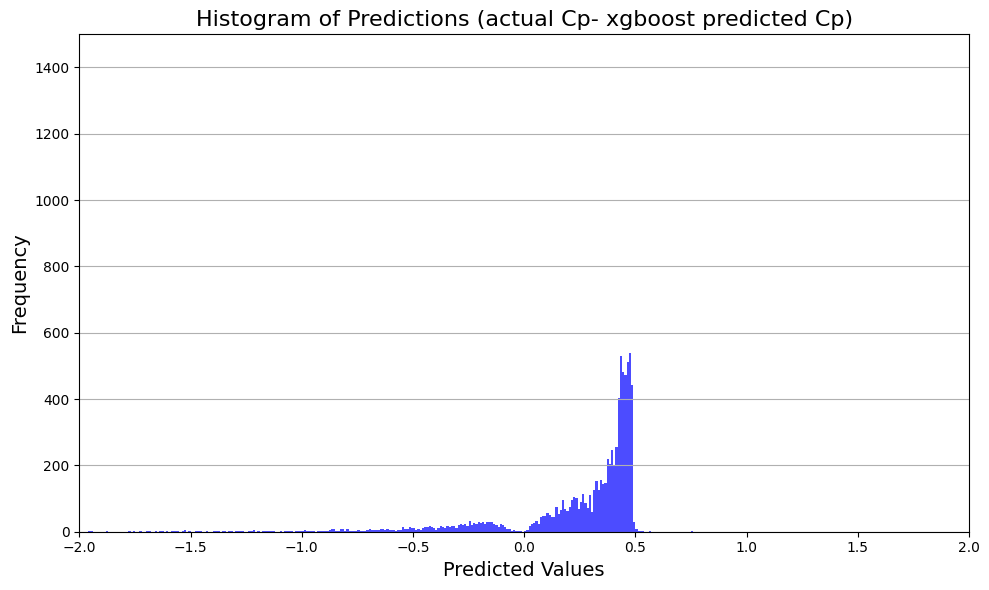

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=1000, range=(-5, 5), color='blue', alpha=0.7)

# Step 2: Set titles and labels
plt.title('Histogram of Predictions (actual Cp- xgboost predicted Cp)', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(-2, 2)  # Adjust the x-axis limits if necessary
plt.grid(axis='y')
plt.ylim(0,1500)
# Step 3: Show the plot
plt.tight_layout()
plt.show()

## theoretical power prediction

In [ ]:
# p_theoretical

merged_df["p_theoretical"] = merged_df["p_wind"] * merged_df["predictions"]

KeyError: 'predictions'

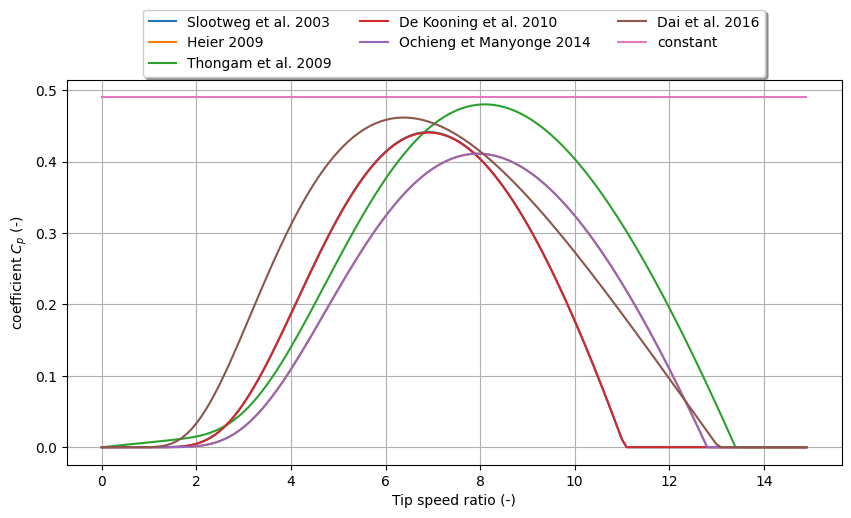

In [ ]:
# Plotting
TSR=np.arange(0,15,0.1)
for Model in ['Slootweg et al. 2003','Heier 2009','Thongam et al. 2009','De Kooning et al. 2010','Ochieng et Manyonge 2014','Dai et al. 2016','constant']:
    Cp=CpLambdaModels(Model,TSR,Beta=[])
    plt.plot(TSR,Cp,label=Model)    
plt.xlabel('Tip speed ratio (-)')
plt.ylabel('coefficient $C_p$ (-)')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, shadow=True, ncol=3)

In the code below, AirDensity, Beta, CpMax should come from data fed into this model

In [ ]:
#make sure the correct model is selected below. This is an example

# AirDensity should be fed from data
def WT_PowerCurve_raw(Vws,Pnom,Drotor,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=0.92): #convEff is loss between measurment and the actual power
    Rrotor = Drotor/2
    Arotor = np.pi*Rrotor**2

    #This is basically a sensitivity approach, i think this can be made more clear
     # ********************************************************************************************
    # 1) Parameterisation of the minimal and maximal rotor rotational speed as a
    # function of the rotor diameter + calculation of VtipMin & VtipMax
    # source: http://publications.lib.chalmers.se/records/fulltext/179591/179591.pdf
    # ********************************************************************************************
    if rMin==[]:
        rMin=188.8*Drotor**(-0.7081)   # minimal angular speed in rpm
    if rMax==[]:
        rMax=793.7*Drotor**(-0.8504);      # maximal angular speed in rpm
    VtipMin=rMin*(2*np.pi*Rrotor)/60   # minimal tip speed in m/s
   
    VtipMax=rMax*(2*np.pi*Rrotor)/60  # maximal tip speed in m/s

        # Calculation of the optimal tip speed ratio and maximal power coefficient
    vTSR=np.arange(0,12,0.001)
    vCp=CpLambdaModels(Model,vTSR,Beta)
    TSR_Opt=np.mean(vTSR[vCp==max(vCp)])

        # ********************************************************************************************
    # 2) Calculation of the tip speed as a function of the wind speed 
    # ********************************************************************************************
    # In ths calculation step, the following assumptions are made:
    # a) the tip speed is set to maximize the energy output (*),
    #    which is achieved by setting lambda to lambdaopt, 
    # b) and assuming that Vtip is always comprised between VtipMin and VtipMax (**)
    # c) using an expression of cp as a function of lambda from (***) (no pitch control
    # assumed (**))
    # Sources:
    # (*) http://mstudioblackboard.tudelft.nl/duwind/Wind%20energy%20online%20reader/Static_pages/Cp_lamda_curve.htm
    # (**) http://www.mdpi.com/1996-1073/10/3/395
    # (***)http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6699403
    # scaling of the power coefficient function if a value is given for CpMax
    if CpMax==[]:
        CpScale=1
        CpMax=max(vCp)
    else:
        CpScale=CpMax/max(vCp)
    
    # Calculation of the tip speed and the tip speed ratio
    Vtip=np.minimum(VtipMax,np.maximum(VtipMin,TSR_Opt*Vws))
    TSR=np.zeros(Vws.shape)
    TSR[Vws>0]=Vtip[Vws>0]/Vws[Vws>0]
        
    # Calculation of the power coefficient
    Cp0=np.maximum(0,ConvEff*CpScale*CpLambdaModels(Model,TSR))

    # Calculation of the input power as a function of air density, wind speed and rotor area #FEED DATA TO THIS ONE #Pin = P_wind
    Pin=0.5*AirDensity*Arotor*(Vws**3)/1000
    Cp=np.zeros(Pin.shape)
    Cp[Pin>0]=np.minimum(Cp0[Pin>0],Pnom/Pin[Pin>0])
    Pout = Cp*Pin

    return Pout

Text(0.5, 1.0, 'Power curve calculated for a wind turbine  with a nominal \n power of 4.0 MW and a rotor diameter of 120 m \n (without consideration of environmental effects and Vcutin/Vcutout)')

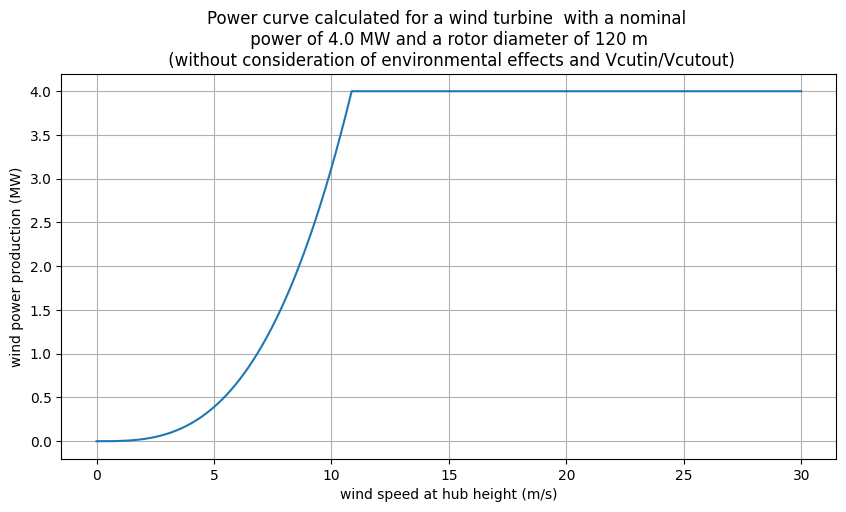

In [ ]:
rMin    = 4
rMax    = 13
Drotor  = 120
Pnom    = 4000
Vws     = np.arange(0,30,0.01)

Pwt=WT_PowerCurve_raw(Vws,Pnom,Drotor,rMin=[],rMax=[],CpMax=[],Model='constant',AirDensity=1.225)
plt.plot(Vws,Pwt/1000)
plt.grid()
plt.xlabel('wind speed at hub height (m/s)')
plt.ylabel('wind power production (MW)')
plt.title('Power curve calculated for a wind turbine  with a nominal \n power of {} MW and a rotor diameter of {} m \n (without consideration of environmental effects and Vcutin/Vcutout)'.format(Pnom/1000,Drotor))

In [ ]:
def calcEffectTI(Vws,Pwt,TI=0.05,Vcutin=3,Vcutoff=25):
    
    #Gaussian filter over w*(1-TI):w*(1+TI), TI being the turbulence intensity
    if TI>0:
        Pwt_ti=0*np.ones(Vws.shape)
        for iws,tWS in enumerate(Vws):
            sigma=TI*tWS
            ix=np.where((Vws>(tWS-5*sigma)) & (Vws<(tWS+5*sigma)))[0]
            weight=np.exp(-0.5*(((Vws[ix]-tWS)/sigma)**2))
            if sum(weight)>0:
                Pwt_ti[iws]=sum(Pwt[ix]*weight)/sum(weight)
    else:
        Pwt_ti=Pwt

    # Setting the power production to zero below the cut-in and above the cut-off wind speeds
    Pwt_ti[Vws<Vcutin]=0
    Pwt_ti[Vws>Vcutoff]=0
    return Pwt_ti


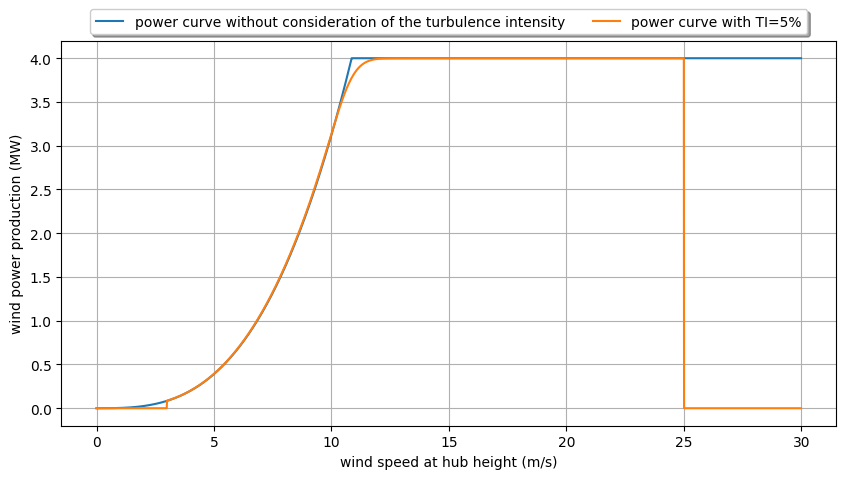

In [ ]:

Pwt_ti=calcEffectTI(Vws,Pwt,TI=0.05,Vcutin=3,Vcutoff=25)

plt.plot(Vws,Pwt/1000,label='power curve without consideration of the turbulence intensity')
plt.plot(Vws,Pwt_ti/1000,label='power curve with TI=5%')
plt.grid()
plt.xlabel('wind speed at hub height (m/s)')
plt.ylabel('wind power production (MW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=True, ncol=2)

In [ ]:
def calcREWS(Vws,zhub,Drotor,Shear,Veer):
    N=10000
    zi=zhub+np.linspace(-Drotor/2,Drotor/2,N)
    dz=Drotor/N
    Ai=(2*np.sqrt((Drotor/2)**2-(zi-zhub)**2))*dz
    A=np.sum(Ai)
    
    CoeffShear=(zi/zhub)**Shear
    CoeffVeer=np.cos((zi-zhub)*Veer*np.pi/180)

    REWS=np.ones(Vws.shape)*np.nan
    for ii,V in enumerate(Vws):
        Vi=V*CoeffShear*CoeffVeer
        REWS[ii]=(np.sum((Vi**3)*Ai/A))**(1/3)
    
    return REWS

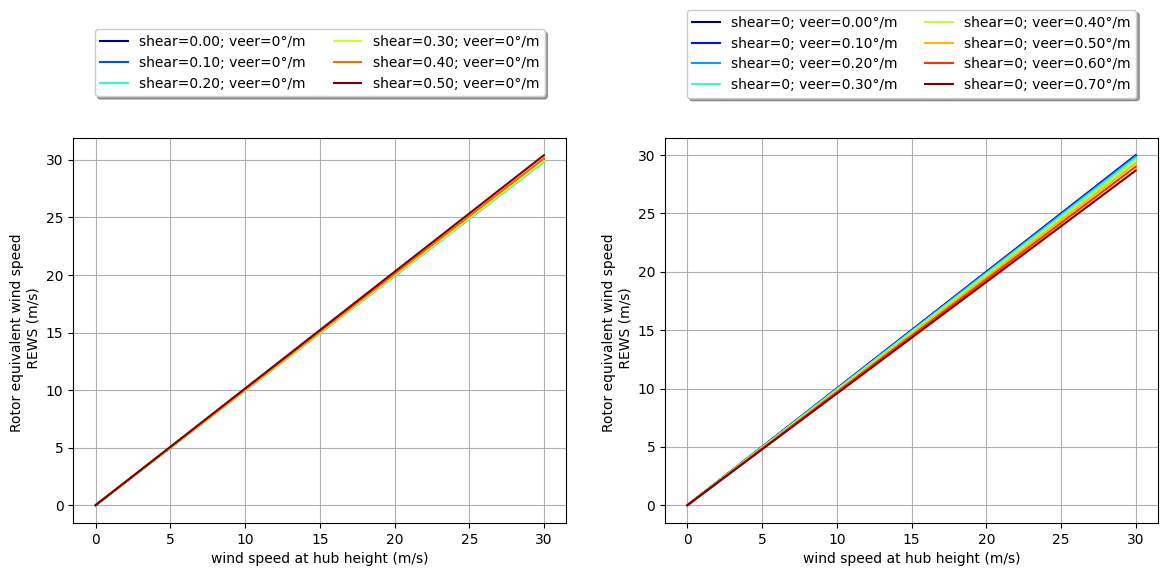

In [ ]:
vShear=np.arange(0,0.6,0.1)
vVeer=np.arange(0,0.8,0.1)

Drotor = 100
zhub   = 75
Vws    = np.arange(0,30,0.01)

fig,axs=plt.subplots(1,2,figsize=(14, 5))

norm = matplotlib.colors.Normalize(vmin=min(vShear), vmax=max(vShear))
for Shear in vShear:
    rgba_color = np.array(cm.jet(norm(Shear),bytes=True))/255
    REWS=calcREWS(Vws,zhub,Drotor,Shear,Veer=0)
    axs[0].plot(Vws,REWS,label='shear={0:.2f}; veer=0°/m'.format(Shear),color=rgba_color)
axs[0].grid()
axs[0].set_xlabel('wind speed at hub height (m/s)')
axs[0].set_ylabel('Rotor equivalent wind speed \n REWS (m/s)')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),fancybox=True, shadow=True, ncol=2)

norm = matplotlib.colors.Normalize(vmin=min(vVeer), vmax=max(vVeer))
for Veer in vVeer:
    rgba_color = np.array(cm.jet(norm(Veer),bytes=True))/255
    REWS=calcREWS(Vws,zhub,Drotor,Shear=0,Veer=Veer)
    axs[1].plot(Vws,REWS,label='shear=0; veer={0:.2f}°/m'.format(Veer),color=rgba_color)

axs[1].grid()
axs[1].set_xlabel('wind speed at hub height (m/s)')
axs[1].set_ylabel('Rotor equivalent wind speed \n REWS (m/s)')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),fancybox=True, shadow=True, ncol=2)

In [ ]:
def GenericWindTurbinePowerCurve(Vws,Pnom,Drotor,zhub=[],Vcutin=3,Vcutoff=25,TI=0.1,Shear=0.15,Veer=0,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=[]):
    
    # conversion losses
    if ConvEff==[]:
        gear_loss_const= .01
        gear_loss_var= .014
        generator_loss= 0.03
        converter_loss= .03
        ConvEff=(1-gear_loss_const)*(1-gear_loss_var)*(1-generator_loss)*(1-converter_loss)
    
    # Estimation of the hub height based on a statistical relationship made using data from thewindpower.net
    if zhub==[]:
        zhub=10.95*Drotor+0.9205 
        
    # Calculation of the rotor equivalent wind speed
    REWS=calcREWS(Vws,zhub,Drotor,Shear,Veer)

    # Calculation of the power curve without consideration of the TI and cut-in and cut-off wind speeds
    Pout_raw=WT_PowerCurve_raw(REWS,Pnom,Drotor,rMin,rMax,CpMax,Model,Beta,AirDensity,ConvEff)

    # Calculation of the effect of the TI, cut-in and cut-off wind speeds on the power curve
    Pwt_ti=calcEffectTI(REWS,Pout_raw,TI,Vcutin,Vcutoff)
   
    return Pwt_ti

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 5)
import GenericWindTurbinePowerCurve as GWTPC

Pnom    = 2000
Drotor  = 80
Vws     = np.arange(0,30,0.01)

Pwt=GWTPC.GenericWindTurbinePowerCurve(Vws,Pnom,Drotor)

plt.plot(Vws,Pwt)
plt.ylabel('wind power (kW)')
plt.xlabel('wind speed (m/s)')
plt.grid()

ModuleNotFoundError: No module named 'GenericWindTurbinePowerCurve'